# Dissertation 

# SENTIMENT ANALYSIS OF FINANCIAL NEWS DATA

This notebook contains only the Sentiment Analysis of Financial News from NYT

Since we have unlabeled data from NYT, we can't validate the models. So first we take labeled financial news corpus and train an test the models choosen for sentiment analysis and then use those modles into our NYT dataset.

- An we will answer one of our RQ here. Which model is having higher accuracy in predicitng the sentiments of financial news data.  

# Datasets, Models and Experiments in this sheet are as under,
 - DATASETS
     - financial_phrasebank dataset - labeled with sentiments
     - NewYork Times dataset - unlabeled
 - MODELS
     - Bi-LSTM with word2vec
     - FinBERT
     - LLM
 - Experiments are as under, 
     - Senti Analysis 1 - Bi-LSTM model with word2vec on financial_phrasebank dataset
     - Senti Analysis 1.1 - Bi-LSTM model with word2vec on NewYork Times dataset
     - Senti Analysis 2 - FinBERT on financial_phrasebank dataset
     - Senti Analysis 2.1 - FinBERT on NewYork Times dataset
     - Senti Analysis 3 - LLM on financial_phrasebank dataset
     - Senti Analysis 3.1 - LLM on NewYork Times dataset

# Senti Analysis 1
# Bi-LSTM model with word2vec on financial_phrasebank dataset

In [4]:
!pip install datasets
!pip install transformers
!pip install openai datasets

In [36]:
#PACKAGES USED 

#baisc
import numpy as np
import pandas as pd

#to load dataset & split
from datasets import load_dataset
from sklearn.model_selection import train_test_split

#for pre-processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#for feature extraction
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import gensim.downloader as api

#for Bi-LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# for FinBERT
from datasets import load_dataset
import pandas as pd

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

#for LLM-ChatGPT Model
import openai
import os
from datasets import load_dataset
import pandas as pd

#performance metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#for charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns

#for saving the results
import pickle

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\deenu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deenu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deenu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\deenu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
#Step 1: Load the dataset and split into train, validation and test dataset
dataset = load_dataset('financial_phrasebank', 'sentences_allagree')
dataset

# Split the dataset into reviews and labels as x and y. 

x = dataset['train']['sentence']
y = dataset['train']['label']


# Split the data into training and test subsets (80% training, 20% testing)
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

# Optionally, further split x_train and y_train into training and validation subsets
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=123)

print(x_train[0:5])

['Construction is scheduled to start in April-June 2007 and to be completed in early 2008 .', '`` The trend in the sports and leisure markets was favorable in the first months of the year .', 'Earnings per share ( EPS ) dropped to EUR 0.21 from EUR 0.31 .', 'Finnish financial group Aktia reports operating profit of EUR 44.4 mn in January-September 2009 , up from EUR 37.3 mn in the corresponding period in 2008 .', 'Olli-Pekka Laine has been appointed as the Chairman and Erkki Pehu-Lehtonen as the Vice Chairman of the Board .']


In [8]:
# Pre-processing 

def preprocess_text(text):
    # Dictionary of contractions and their expanded forms
    contractions = {
        "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", 
        "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", 
        "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", 
        "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he shall", 
        "he'll've": "he shall have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
        "how's": "how is", "i'd": "I would", "i'd've": "I would have", "i'll": "I will", "i'll've": "I will have", 
        "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
        "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", 
        "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", 
        "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
        "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
        "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
        "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
        "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", 
        "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
        "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would", 
        "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
        "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
        "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", 
        "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", 
        "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", 
        "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", 
        "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
        "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
        "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", 
        "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
        "you're": "you are", "you've": "you have"
    }

    # Replace contractions
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text.lower())
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Stem the tokens
    #stemmer = PorterStemmer()
    #stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    #since stemming is creating some spelling mistakes which may affect the contextual representation, we have not performed this. eg: Centurys ----stemming---> centuri

    #lemmatizing the tokens
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the stemmed tokens
    preprocessed_text = ' '.join(lemma_tokens)
    
    return preprocessed_text

# apply this in x_train, x_val, and x_test,
x_train_preprocessed = [preprocess_text(text) for text in x_train]
x_val_preprocessed = [preprocess_text(text) for text in x_val]
x_test_preprocessed = [preprocess_text(text) for text in x_test]

print(x_train_preprocessed[0:5])

['construction scheduled start apriljune completed early', 'trend sport leisure market favorable first month year', 'earnings per share eps dropped eur eur', 'finnish financial group aktia report operating profit eur mn januaryseptember eur mn corresponding period', 'ollipekka laine appointed chairman erkki pehulehtonen vice chairman board']


In [9]:
# Train and Test the text in Bi-LSTM with pre-trained Word2Vec 

np.random.seed(123)
tf.random.set_seed(123)

#tokenizing and sequencing 
tokenizer = Tokenizer(nb_words=5000)
tokenizer.fit_on_texts(x_train_preprocessed)
tokenizer.fit_on_texts(x_val_preprocessed)
tokenizer.fit_on_texts(x_test_preprocessed)

train_sequences = tokenizer.texts_to_sequences(x_train_preprocessed)
val_sequences = tokenizer.texts_to_sequences(x_val_preprocessed)
test_sequences = tokenizer.texts_to_sequences(x_test_preprocessed)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

pad_len = 50

#train data into padded input
x_train_preprocessed_pad = pad_sequences(train_sequences, maxlen=pad_len)
x_val_preprocessed_pad = pad_sequences(val_sequences, maxlen=pad_len)
x_test_preprocessed_pad = pad_sequences(test_sequences, maxlen=pad_len)


word2vec_model = api.load('word2vec-google-news-300')
#to import GoogleNews-vectors-negative300.bin.gz from online - took 10 mins, so for trial and errors mounting drive and executing, 


#embedding dimension
embed_dim = word2vec_model.vector_size

# Create a dictionary of word embeddings
embeddings_index = {}
for word in word2vec_model.key_to_index:
    embeddings_index[word] = word2vec_model.get_vector(word)

print('Found %s word vectors.' % len(embeddings_index))

#create embeding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

C:\Users\deenu\anaconda3\lib\site-packages\keras\src\preprocessing\text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Found 4918 unique tokens.
Found 3000000 word vectors.


In [11]:

#Creating Model
model_wv = Sequential()
model_wv.add(Embedding(len(word_index) + 1,
                            embed_dim,
                            weights=[embedding_matrix],
                            input_length=pad_len,
                            trainable=False))
model_wv.add(Bidirectional(LSTM(100)))
model_wv.add(Dense(3, activation="softmax"))
model_wv.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print('model_wv summary', model_wv.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           1475700   
                                                                 
 bidirectional (Bidirection  (None, 200)               320800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 3)                 603       
                                                                 
Total params: 1797103 (6.86 MB)
Trainable params: 321403 (1.23 MB)
Non-trainable params: 1475700 (5.63 MB)
_________________________________________________________________
model_wv summary None


In [12]:

#convert to array
x_train_final = np.array(x_train_preprocessed_pad)
x_val_final = np.array(x_val_preprocessed_pad)
x_test_final = np.array(x_test_preprocessed_pad)
y_train_final = np.array(y_train)
y_val_final = np.array(y_val)
y_test_final = np.array(y_test)

#traintest split
#from sklearn.model_selection import train_test_split
#x_trainsplit, x_testsplit, y_trainsplit, y_testsplit = train_test_split(x_train_pad, y_train, test_size=0.2, random_state=42)

# Model Training
trained_model = model_wv.fit(x_train_final, y_train_final, epochs=15, batch_size=16, validation_data=(x_val_final, y_val_final))


Epoch 1/15
85/85 [==============================] - 7s 46ms/step - loss: 0.6693 - accuracy: 0.7216 - val_loss: 0.4994 - val_accuracy: 0.7815
Epoch 2/15
85/85 [==============================] - 3s 41ms/step - loss: 0.4891 - accuracy: 0.7717 - val_loss: 0.4353 - val_accuracy: 0.8234
Epoch 3/15
85/85 [==============================] - 4s 48ms/step - loss: 0.3747 - accuracy: 0.8358 - val_loss: 0.3649 - val_accuracy: 0.8631
Epoch 4/15
85/85 [==============================] - 4s 43ms/step - loss: 0.3041 - accuracy: 0.8785 - val_loss: 0.4176 - val_accuracy: 0.8565
Epoch 5/15
85/85 [==============================] - 4s 44ms/step - loss: 0.2288 - accuracy: 0.9057 - val_loss: 0.3477 - val_accuracy: 0.8698
Epoch 6/15
85/85 [==============================] - 4s 44ms/step - loss: 0.1880 - accuracy: 0.9256 - val_loss: 0.2991 - val_accuracy: 0.8940
Epoch 7/15
85/85 [==============================] - 4s 42ms/step - loss: 0.1565 - accuracy: 0.9381 - val_loss: 0.3661 - val_accuracy: 0.8499
Epoch 8/15
85

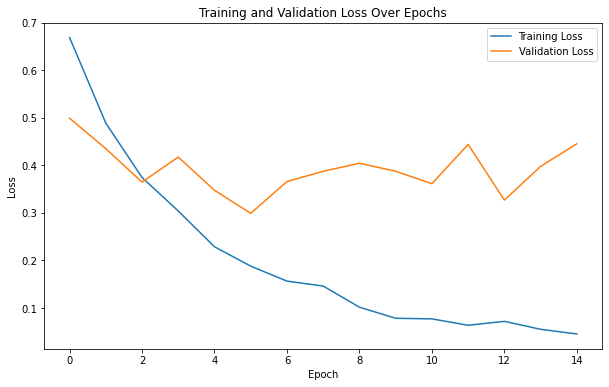

In [13]:
# Plotting Train vs. Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(trained_model.history['loss'], label='Training Loss')
plt.plot(trained_model.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:

#predict
test_pred_prob = model_wv.predict(x_test_final)

# Converting probabilities to class labels
test_pred = np.argmax(test_pred_prob, axis=1)


15/15 [==============================] - 1s 16ms/step


accuracy : 0.8896247240618101
              precision    recall  f1-score   support

           0       0.78      0.71      0.75        56
           1       0.92      0.97      0.94       290
           2       0.85      0.78      0.81       107

    accuracy                           0.89       453
   macro avg       0.85      0.82      0.83       453
weighted avg       0.89      0.89      0.89       453



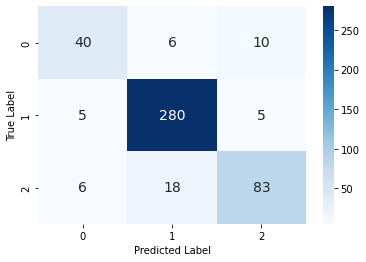

In [22]:
# performance metrics of the Model:

# Test accuracy
accuracy = accuracy_score(y_test_final, test_pred)
print ('accuracy :', accuracy)

# per metrics
print(classification_report(y_test_final, test_pred))

# Test - confusion matrix
cm = confusion_matrix(y_test_final, test_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', annot_kws={"fontsize":14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

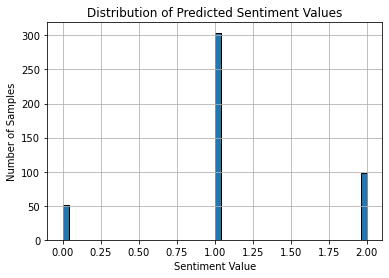

In [23]:
import matplotlib.pyplot as plt
# Plotting the histogram for predicted values
plt.hist(test_pred, bins=50, edgecolor='black')
plt.title('Distribution of Predicted Sentiment Values')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

# Inferance: 
We got 87% of accuracy in predicting the financial_phrasebank dataset using the Bi-LSTM model with word2vec

# Senti Analysis 1.1
# Bi-LSTM with word2vec on NYT dataset

We extracted 10 years of Financial News from New York Times with an Article Search API with the querry word Apple. Due to extraction limitations we have extracted in 10 differnt files. So, need to join those and proceed in analysis.

In [116]:
# Joining 10 years of news in one data frame.

filenames = ["FinancialNews2013.csv",
             "FinancialNews2014.csv",
             "FinancialNews2015.csv",
             "FinancialNews2016.csv",
             "FinancialNews2017-18.csv",
             "FinancialNews2019.csv",
             "FinancialNews2020.csv",
             "FinancialNews2021.csv",
             "FinancialNews2022.csv",
             "FinancialNews2023.csv",
             ]

dataframes = []

for filename in filenames:
    try:
        df = pd.read_csv(filename, encoding='utf-8')
    except UnicodeDecodeError:
        try:
            df = pd.read_csv(filename, encoding='cp1252')
        except UnicodeDecodeError:
            df = pd.read_csv(filename, encoding='ISO-8859-1', errors='replace')

    dataframes.append(df)

AAPL_fn_data = pd.concat(dataframes, ignore_index=True)
AAPL_fn_data

,Pub Date,Headline,Snippet,Lead Paragraph,abstract,Source,Web URL
0,2013-01-10T13:00:48+0000,"The 2012 Patent Rankings: IBM on Top (Again), ...",The yearly count of corporate patent winners s...,In the yearly count of patents granted in the...,The yearly count of corporate patent winners s...,The New York Times,https://bits.blogs.nytimes.com/2013/01/10/the-...
1,2013-01-07T03:04:20+0000,Providing a Template to Challenge Apple,MediaTek of Taiwan not only provides manufactu...,"TAIPEI — In the China smartphone market, Apple...",MediaTek of Taiwan not only provides manufactu...,The New York Times,https://www.nytimes.com/2013/01/07/technology/...
2,2013-01-09T21:16:18+0000,Q&A: Making the Mac Take Dictation,The built-in Dictation feature of OS X 10.8 fo...,Q.,The built-in Dictation feature of OS X 10.8 fo...,The New York Times,https://gadgetwise.blogs.nytimes.com/2013/01/0...
3,2013-01-04T23:00:23+0000,Digital Connections Will Increase as a Selling...,The I.B.M. study shows that buyers will increa...,AUTOMAKERS are racing to ramp up their digital...,The I.B.M. study shows that buyers will increa...,The New York Times,https://www.nytimes.com/2013/01/06/automobiles...
4,2013-01-04T00:46:25+0000,Inquiry Into Tech Giants’ Tax Strategies Nears...,Companies like Apple have drawn scrutiny becau...,Congressional investigators are wrapping up an...,Companies like Apple have drawn scrutiny becau...,The New York Times,https://www.nytimes.com/2013/01/04/business/an...
...,...,...,...,...,...,...,...
3976,2023-07-21T15:43:38+0000,Colson Whitehead on ‘Crook Manifesto’ and Harl...,The Pulitzer-winning novelist discusses the se...,Gilbert Cruz is joined by two-time Pulitzer Pr...,The Pulitzer-winning novelist discusses the se...,The New York Times,https://www.nytimes.com/2023/07/21/books/revie...
3977,2023-07-27T00:00:00+0000,Grilled Pork Chops With Plum BBQ Sauce,NaN,"The bright, sweet-tart flavor of ripe plums co...",NaN,NaN,https://cooking.nytimes.com/recipes/1024461-gr...
3978,2023-07-23T09:04:17+0000,"It’s Simple: Fewer Watches, Higher Prices","“Let’s face the reality,” one executive said, ...","In 2022, the value of Swiss watch exports reac...","“Let’s face the reality,” one executive said, ...",International New York Times,https://www.nytimes.com/2023/07/23/fashion/wat...
3979,2023-07-26T09:00:12+0000,‘Oppenheimer’ and the Siren Song of World-Endi...,The story is a warning. Will we heed it?,Christopher Nolan’s blockbuster hit “Oppenheim...,The story is a warning. Will we heed it?,The New York Times,https://www.nytimes.com/2023/07/26/opinion/opp...


In [117]:
AAPL_fn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3981 entries, 0 to 3980
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Pub Date        3981 non-null   object
 1   Headline        3981 non-null   object
 2   Snippet         3834 non-null   object
 3   Lead Paragraph  3954 non-null   object
 4   abstract        3850 non-null   object
 5   Source          3849 non-null   object
 6   Web URL         3981 non-null   object
dtypes: object(7)
memory usage: 217.8+ KB


In [118]:
AAPL_fn_data.describe()

,Pub Date,Headline,Snippet,Lead Paragraph,abstract,Source,Web URL
count,3981,3981,3834,3954,3850,3849,3981
unique,3960,3949,3787,3613,3803,8,3981
top,2018-09-04T00:00:00+0000,5 Things to Do This Weekend,Here’s what you need to know to start your day.,Listen and subscribe to our podcast from your ...,Here’s what you need to know to start your day.,The New York Times,https://bits.blogs.nytimes.com/2013/01/10/the-...
freq,4,11,13,117,13,3704,1


In [119]:
AAPL_fn_data

,Pub Date,Headline,Snippet,Lead Paragraph,abstract,Source,Web URL
0,2013-01-10T13:00:48+0000,"The 2012 Patent Rankings: IBM on Top (Again), ...",The yearly count of corporate patent winners s...,In the yearly count of patents granted in the...,The yearly count of corporate patent winners s...,The New York Times,https://bits.blogs.nytimes.com/2013/01/10/the-...
1,2013-01-07T03:04:20+0000,Providing a Template to Challenge Apple,MediaTek of Taiwan not only provides manufactu...,"TAIPEI — In the China smartphone market, Apple...",MediaTek of Taiwan not only provides manufactu...,The New York Times,https://www.nytimes.com/2013/01/07/technology/...
2,2013-01-09T21:16:18+0000,Q&A: Making the Mac Take Dictation,The built-in Dictation feature of OS X 10.8 fo...,Q.,The built-in Dictation feature of OS X 10.8 fo...,The New York Times,https://gadgetwise.blogs.nytimes.com/2013/01/0...
3,2013-01-04T23:00:23+0000,Digital Connections Will Increase as a Selling...,The I.B.M. study shows that buyers will increa...,AUTOMAKERS are racing to ramp up their digital...,The I.B.M. study shows that buyers will increa...,The New York Times,https://www.nytimes.com/2013/01/06/automobiles...
4,2013-01-04T00:46:25+0000,Inquiry Into Tech Giants’ Tax Strategies Nears...,Companies like Apple have drawn scrutiny becau...,Congressional investigators are wrapping up an...,Companies like Apple have drawn scrutiny becau...,The New York Times,https://www.nytimes.com/2013/01/04/business/an...
...,...,...,...,...,...,...,...
3976,2023-07-21T15:43:38+0000,Colson Whitehead on ‘Crook Manifesto’ and Harl...,The Pulitzer-winning novelist discusses the se...,Gilbert Cruz is joined by two-time Pulitzer Pr...,The Pulitzer-winning novelist discusses the se...,The New York Times,https://www.nytimes.com/2023/07/21/books/revie...
3977,2023-07-27T00:00:00+0000,Grilled Pork Chops With Plum BBQ Sauce,NaN,"The bright, sweet-tart flavor of ripe plums co...",NaN,NaN,https://cooking.nytimes.com/recipes/1024461-gr...
3978,2023-07-23T09:04:17+0000,"It’s Simple: Fewer Watches, Higher Prices","“Let’s face the reality,” one executive said, ...","In 2022, the value of Swiss watch exports reac...","“Let’s face the reality,” one executive said, ...",International New York Times,https://www.nytimes.com/2023/07/23/fashion/wat...
3979,2023-07-26T09:00:12+0000,‘Oppenheimer’ and the Siren Song of World-Endi...,The story is a warning. Will we heed it?,Christopher Nolan’s blockbuster hit “Oppenheim...,The story is a warning. Will we heed it?,The New York Times,https://www.nytimes.com/2023/07/26/opinion/opp...


In [120]:
# Change the date format, sort with date, concat headlines and abstract. 

AAPL_fn_data['Pub Date'] = pd.to_datetime(AAPL_fn_data['Pub Date']).dt.strftime('%Y-%m-%d')
AAPL_fn_data = AAPL_fn_data.sort_values(by='Pub Date')
AAPL_fn_data ['Headline+abstract'] = AAPL_fn_data['Headline'] + ' : ' + AAPL_fn_data['abstract']
AAPL_fn_data

,Pub Date,Headline,Snippet,Lead Paragraph,abstract,Source,Web URL,Headline+abstract
7,2013-01-01,"As Taiwan’s Links With Mainland Grow, So Do Co...",Fears are growing that the Chinese mainland is...,TAIPEI — The 188-second flurry of fireworks th...,Fears are growing that the Chinese mainland is...,The New York Times,https://rendezvous.blogs.nytimes.com/2013/01/0...,"As Taiwan’s Links With Mainland Grow, So Do Co..."
6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again","On the morning of New Year’s Day, many iPhone ...",2:01 p.m. | Updated Adding response from Apple.,"On the morning of New Year’s Day, many iPhone ...",The New York Times,https://bits.blogs.nytimes.com/2013/01/02/ipho...,"The iPhone Goofs Up on Telling Time, Again : O..."
5,2013-01-03,Tip of the Week: How to Control the Music in i...,If the full iTunes 11 window takes up too much...,Apple’s recent overhaul of its iTunes music-ma...,If the full iTunes 11 window takes up too much...,The New York Times,https://gadgetwise.blogs.nytimes.com/2013/01/0...,Tip of the Week: How to Control the Music in i...
3,2013-01-04,Digital Connections Will Increase as a Selling...,The I.B.M. study shows that buyers will increa...,AUTOMAKERS are racing to ramp up their digital...,The I.B.M. study shows that buyers will increa...,The New York Times,https://www.nytimes.com/2013/01/06/automobiles...,Digital Connections Will Increase as a Selling...
4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...,Companies like Apple have drawn scrutiny becau...,Congressional investigators are wrapping up an...,Companies like Apple have drawn scrutiny becau...,The New York Times,https://www.nytimes.com/2013/01/04/business/an...,Inquiry Into Tech Giants’ Tax Strategies Nears...
...,...,...,...,...,...,...,...,...
3979,2023-07-26,‘Oppenheimer’ and the Siren Song of World-Endi...,The story is a warning. Will we heed it?,Christopher Nolan’s blockbuster hit “Oppenheim...,The story is a warning. Will we heed it?,The New York Times,https://www.nytimes.com/2023/07/26/opinion/opp...,‘Oppenheimer’ and the Siren Song of World-Endi...
3972,2023-07-27,Warren and Graham Team Up to Take on Big Tech,The senators have forged a bipartisan alliance...,"For years, policymakers have worried about the...",The senators have forged a bipartisan alliance...,The New York Times,https://www.nytimes.com/2023/07/27/business/de...,Warren and Graham Team Up to Take on Big Tech ...
3971,2023-07-27,‘The Beanie Bubble’ Review: Caught in a Fad Ro...,"This dramatic comedy about Beanie Babies, star...",John Updike once described writing as a matter...,"This dramatic comedy about Beanie Babies, star...",The New York Times,https://www.nytimes.com/2023/07/27/movies/the-...,‘The Beanie Bubble’ Review: Caught in a Fad Ro...
3977,2023-07-27,Grilled Pork Chops With Plum BBQ Sauce,NaN,"The bright, sweet-tart flavor of ripe plums co...",NaN,NaN,https://cooking.nytimes.com/recipes/1024461-gr...,NaN


In [121]:
# Now pick date and headline + abstract column for analysis

AAPL_fn_data_ana = AAPL_fn_data
AAPL_fn_data_ana = AAPL_fn_data_ana.drop(columns=['Headline', 'Snippet', 'Lead Paragraph', 'abstract', 'Source', 'Web URL'])
AAPL_fn_data_ana

,Pub Date,Headline+abstract
7,2013-01-01,"As Taiwan’s Links With Mainland Grow, So Do Co..."
6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O..."
5,2013-01-03,Tip of the Week: How to Control the Music in i...
3,2013-01-04,Digital Connections Will Increase as a Selling...
4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...
...,...,...
3979,2023-07-26,‘Oppenheimer’ and the Siren Song of World-Endi...
3972,2023-07-27,Warren and Graham Team Up to Take on Big Tech ...
3971,2023-07-27,‘The Beanie Bubble’ Review: Caught in a Fad Ro...
3977,2023-07-27,NaN


In [122]:
rows_with_na6 = AAPL_fn_data_ana[AAPL_fn_data_ana.isna().any(axis=1)]
print(len(rows_with_na6))

# Identify indices of rows with NaN values
indices_to_drop = rows_with_na6.index

# Drop these rows from apple_ds
AAPL_fn_data_ana = AAPL_fn_data_ana.drop(indices_to_drop)
AAPL_fn_data_ana

131


,Pub Date,Headline+abstract
7,2013-01-01,"As Taiwan’s Links With Mainland Grow, So Do Co..."
6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O..."
5,2013-01-03,Tip of the Week: How to Control the Music in i...
3,2013-01-04,Digital Connections Will Increase as a Selling...
4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...
...,...,...
3975,2023-07-25,"Psychedelic Therapy, Threads vs. Twitter, My N..."
3979,2023-07-26,‘Oppenheimer’ and the Siren Song of World-Endi...
3972,2023-07-27,Warren and Graham Team Up to Take on Big Tech ...
3971,2023-07-27,‘The Beanie Bubble’ Review: Caught in a Fad Ro...


In [123]:
# Lets remove the news not related to Apple

# Keywords related to Apple
keywords = [
    'apple', 'iphone', 'ipad', 'mac', 'macbook', 'ios', 'ipod',
    'airpods', 'apple watch', 'apple tv', 'icloud', 'itunes',
    'imac', 'apple pencil', 'apple pay', 'macos', 'watchos',
    'app store', 'airtag', 'mac mini', 'mac pro', 'homepod',
    'apple music', 'apple arcade', 'applecare'
]

# Filter the DataFrame based on keywords
AAPL_filtered_df = AAPL_fn_data_ana[AAPL_fn_data_ana['Headline+abstract'].str.lower().str.contains('|'.join(keywords))]

headline = AAPL_filtered_df['Headline+abstract']
headline

6       The iPhone Goofs Up on Telling Time, Again : O...
5       Tip of the Week: How to Control the Music in i...
4       Inquiry Into Tech Giants’ Tax Strategies Nears...
1       Providing a Template to Challenge Apple : Medi...
2       Q&A: Making the Mac Take Dictation : The built...
                              ...                        
3958    Popcast (Deluxe): Olivia Rodrigo Returns, Fall...
3954    America, Shall I Compare Thee to a Chevy Volt?...
3953    This MacBook Air Is $200 Off for Prime Day, th...
3965    The 23 Best Apple Deals of Amazon Prime Day 20...
3972    Warren and Graham Team Up to Take on Big Tech ...
Name: Headline+abstract, Length: 2113, dtype: object

# Modeling starts here

In [124]:

def preprocess_text(text):
    # Dictionary of contractions and their expanded forms
    contractions = {
        "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", 
        "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", 
        "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", 
        "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he shall", 
        "he'll've": "he shall have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
        "how's": "how is", "i'd": "I would", "i'd've": "I would have", "i'll": "I will", "i'll've": "I will have", 
        "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
        "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", 
        "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", 
        "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
        "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
        "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
        "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
        "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", 
        "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", 
        "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would", 
        "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
        "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
        "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", 
        "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", 
        "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", 
        "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", 
        "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
        "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
        "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", 
        "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
        "you're": "you are", "you've": "you have"
    }

    # Replace contractions
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text.lower())
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Stem the tokens
    #stemmer = PorterStemmer()
    #stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    #since stemming is creating some spelling mistakes which may affect the contextual representation, we have not performed this. eg: Centurys ----stemming---> centuri

    #lemmatizing the tokens
    lemmatizer = WordNetLemmatizer()
    lemma_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the stemmed tokens
    preprocessed_text = ' '.join(lemma_tokens)
    
    return preprocessed_text

# apply this in x_train, x_val, and x_test,
headlines_preprocessed = [preprocess_text(text) for text in headline]

print(headlines_preprocessed[0:5])

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\deenu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deenu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deenu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\deenu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['iphone goof telling time morning new year day many iphone user affected bug disturb feature feature apple promoted commercial broadcast week', 'tip week control music itunes full itunes window take much screen space shrink still control music', 'inquiry tech giant tax strategy nears end company like apple drawn scrutiny penchant shifting profit overseas resulting low american tax bill', 'providing template challenge apple mediatek taiwan provides manufacturer chip smartphones also tell build run cutting cost compete iphone', 'qa making mac take dictation builtin dictation feature o x mac convert word text']


In [125]:
# Test the text in Bi-LSTM with pre-trained Word2Vec 

np.random.seed(123)
tf.random.set_seed(123)

#tokenizing and sequencing 
tokenizer = Tokenizer(nb_words=8000)
tokenizer.fit_on_texts(headlines_preprocessed)
headlines_sequences = tokenizer.texts_to_sequences(headlines_preprocessed)

#unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

pad_len = 100

#converting data to the padded length
headlines_preprocessed_pad = pad_sequences(headlines_sequences, maxlen=pad_len)

#load word2vec
#word2vec_model = api.load('word2vec-google-news-300')
#to import GoogleNews-vectors-negative300.bin.gz from online - took 10 mins.

#embedding dimension
embed_dim = word2vec_model.vector_size

# Create a dictionary of word embeddings
embeddings_index = {}
for word in word2vec_model.key_to_index:
    embeddings_index[word] = word2vec_model.get_vector(word)

print('Found %s word vectors.' % len(embeddings_index))


Found 7658 unique tokens.


C:\Users\deenu\anaconda3\lib\site-packages\keras\src\preprocessing\text.py:246: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


Found 3000000 word vectors.


In [126]:

#create embeding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


#Creating Model
model_wv = Sequential()
model_wv.add(Embedding(len(word_index) + 1,
                            embed_dim,
                            weights=[embedding_matrix],
                            input_length=pad_len,
                            trainable=False))
model_wv.add(Bidirectional(LSTM(100)))
model_wv.add(Dense(3, activation="softmax"))
model_wv.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print('model_wv summary', model_wv.summary())

#convert to array
x_test_final = np.array(headlines_preprocessed_pad)

#predict
test_pred_prob = model_wv.predict(x_test_final)
test_pred = np.argmax(test_pred_prob, axis=1)
test_pred_prob

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          2297700   
                                                                 
 bidirectional_2 (Bidirecti  (None, 200)               320800    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 3)                 603       
                                                                 
Total params: 2619103 (9.99 MB)
Trainable params: 321403 (1.23 MB)
Non-trainable params: 2297700 (8.77 MB)
_________________________________________________________________
model_wv summary None
67/67 [==============================] - 2s 28ms/step


array([[0.32973346, 0.31753087, 0.35273567],
       [0.3266618 , 0.360508  , 0.3128302 ],
       [0.30781874, 0.3592246 , 0.33295673],
       ...,
       [0.3140029 , 0.3397098 , 0.34628725],
       [0.30995056, 0.3472786 , 0.34277087],
       [0.30860138, 0.33605838, 0.35534027]], dtype=float32)

In [127]:
test_pred_prob

array([[0.32973346, 0.31753087, 0.35273567],
       [0.3266618 , 0.360508  , 0.3128302 ],
       [0.30781874, 0.3592246 , 0.33295673],
       ...,
       [0.3140029 , 0.3397098 , 0.34628725],
       [0.30995056, 0.3472786 , 0.34277087],
       [0.30860138, 0.33605838, 0.35534027]], dtype=float32)

In [128]:
test_pred

array([2, 1, 1, ..., 2, 1, 2], dtype=int64)

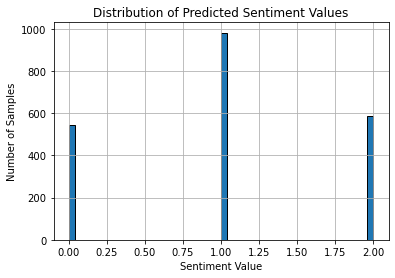

In [129]:
# Plotting the histogram for predicted values
plt.hist(test_pred, bins=50, edgecolor='black')
plt.title('Distribution of Predicted Sentiment Values')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

# NOTE: 
The Senti Analysis 1.1 - Bi-LSTM word2vec on NYT dataset is done. 

# Now merge the sentiments against the dates and make it ready for the main analysis(i.e. stock price prediciton)

In [130]:
# Create new results_df with Pub Date and the sentiment values
results_df = pd.DataFrame({
    'Pub Date': AAPL_filtered_df['Pub Date'],
    'Headline+abstract': AAPL_filtered_df['Headline+abstract'] ,
    'Sentiment': test_pred.flatten(),  # Flatten is used to make sure the shape is consistent
    'Senti Prob': np.max(test_pred_prob, axis=1)
})
results_df

,Pub Date,Headline+abstract,Sentiment,Senti Prob
6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O...",2,0.352736
5,2013-01-03,Tip of the Week: How to Control the Music in i...,1,0.360508
4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...,1,0.359225
1,2013-01-07,Providing a Template to Challenge Apple : Medi...,2,0.365470
2,2013-01-09,Q&A: Making the Mac Take Dictation : The built...,2,0.358309
...,...,...,...,...
3958,2023-07-05,"Popcast (Deluxe): Olivia Rodrigo Returns, Fall...",2,0.334083
3954,2023-07-06,"America, Shall I Compare Thee to a Chevy Volt?...",1,0.358520
3953,2023-07-10,"This MacBook Air Is $200 Off for Prime Day, th...",2,0.346287
3965,2023-07-11,The 23 Best Apple Deals of Amazon Prime Day 20...,1,0.347279


In [131]:
duplicates = results_df[results_df['Pub Date'].duplicated(keep=False)]
duplicates

,Pub Date,Headline+abstract,Sentiment,Senti Prob
19,2013-01-14,Google Gains From Creating Apps for the Opposi...,2,0.353884
17,2013-01-14,Daily Report: Google Invades the iPhone : For ...,1,0.342183
12,2013-01-17,AT&T Allows FaceTime for Limited Data Users. W...,1,0.337930
10,2013-01-17,Digital Notes: Amazon Enters Apple’s Phones to...,2,0.356004
20,2013-01-24,"For Investors, Apple Not as Shiny : The Times'...",1,0.346672
...,...,...,...,...
3914,2023-05-22,Companies Are Taking a Harder Line on Union Or...,1,0.355731
3922,2023-06-06,Can Apple Take the Metaverse Mainstream? : The...,1,0.347171
3925,2023-06-06,Why I Can’t Bet Against Apple’s Mixed-Reality ...,1,0.349032
3926,2023-06-06,"A First Try of Apple’s $3,500 Vision Pro Heads...",2,0.335735


In [132]:
# keeping the date column unique and moving the 2nd, 3rd ... news of the same day to separate columns 
#(this is done to ease the merge with the fundamental data)

# Placeholder for the new dataframe's data
new_data = []

# Grouping by 'Pub Date'
grouped = results_df.groupby('Pub Date')

# Iterate over each group
for date, group in grouped:
    # Create a temporary dictionary to hold this group's data
    temp = {'Pub Date': date}
    
    # Iterate over the rows in the group
    for idx, row in enumerate(group.iterrows()):
        if idx == 0:
            temp['Sentiment_1'] = row[1]['Sentiment']
            temp['Senti_Prob_1'] = row[1]['Senti Prob']
        else:
            temp[f'Sentiment_{idx + 1}'] = row[1]['Sentiment']
            temp[f'Senti_Prob_{idx + 1}'] = row[1]['Senti Prob']
    
    new_data.append(temp)

# Convert the list of dictionaries to a DataFrame
reshaped_df = pd.DataFrame(new_data)
reshaped_df

,Pub Date,Sentiment_1,Senti_Prob_1,Sentiment_2,Senti_Prob_2,Sentiment_3,Senti_Prob_3,Sentiment_4,Senti_Prob_4,Sentiment_5,Senti_Prob_5,Sentiment_6,Senti_Prob_6
0,2013-01-02,2,0.352736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,1,0.360508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,1,0.359225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,2,0.365470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-09,2,0.358309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,2023-07-05,2,0.334083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1470,2023-07-06,1,0.358520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1471,2023-07-10,2,0.346287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1472,2023-07-11,1,0.347279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
no_nan_rows = reshaped_df.dropna()
no_nan_rows

,Pub Date,Sentiment_1,Senti_Prob_1,Sentiment_2,Senti_Prob_2,Sentiment_3,Senti_Prob_3,Sentiment_4,Senti_Prob_4,Sentiment_5,Senti_Prob_5,Sentiment_6,Senti_Prob_6
122,2013-09-10,1,0.358310,1.0,0.341335,2.0,0.342922,2.0,0.342035,2.0,0.338882,1.0,0.342000
621,2016-08-31,1,0.361369,2.0,0.342790,2.0,0.348922,1.0,0.386792,1.0,0.343665,0.0,0.385783


In [134]:
# This is to have one dominant sentiment for a day, because most of the rows are having 2 to 3 news.

# Create new columns for counts of 0s, 1s, and 2s
reshaped_df['Count_0'] = 0
reshaped_df['Count_1'] = 0
reshaped_df['Count_2'] = 0

# Iterate over rows
for idx, row in reshaped_df.iterrows():
    # Extract sentiment columns
    sentiments = [row[f'Sentiment_{i}'] for i in range(1, 7) if not np.isnan(row[f'Sentiment_{i}'])]
    
    # Count 0s, 1s, and 2s
    count_0 = sentiments.count(0)
    count_1 = sentiments.count(1)
    count_2 = sentiments.count(2)
    
    # Assign counts to respective columns
    reshaped_df.at[idx, 'Count_0'] = count_0
    reshaped_df.at[idx, 'Count_1'] = count_1
    reshaped_df.at[idx, 'Count_2'] = count_2

    # Set initial dominant sentiment based on counts
    if count_0 > count_1 and count_0 > count_2:
        reshaped_df.at[idx, 'Dominant_Sentiment'] = 0
    elif count_1 > count_0 and count_1 > count_2:
        reshaped_df.at[idx, 'Dominant_Sentiment'] = 1
    elif count_2 > count_0 and count_2 > count_1:
        reshaped_df.at[idx, 'Dominant_Sentiment'] = 2

    # Check conditions
    else:
        if count_0 == count_1:
            reshaped_df.at[idx, 'Dominant_Sentiment'] = 0
        elif count_2 == count_1:
            reshaped_df.at[idx, 'Dominant_Sentiment'] = 2
        elif count_0 == count_2:
            # Extract senti_score
            senti_probs = [row[f'Senti_Prob_{i}'] for i in range(1, 7) if not np.isnan(row[f'Senti_Prob_{i}'])]

            # Find the sentiment with the maximum senti_probs
            max_senti_probs = max(senti_probs)

            for i in range(1, 7):
                if row[f'Senti_Prob_{i}'] == max_senti_probs:
                    reshaped_df.at[idx, 'Dominant_Sentiment'] = row[f'Sentiment_{i}']
                    break
reshaped_df.tail(60)

,Pub Date,Sentiment_1,Senti_Prob_1,Sentiment_2,Senti_Prob_2,Sentiment_3,Senti_Prob_3,Sentiment_4,Senti_Prob_4,Sentiment_5,Senti_Prob_5,Sentiment_6,Senti_Prob_6,Count_0,Count_1,Count_2,Dominant_Sentiment
1414,2022-11-15,1,0.350469,2.0,0.338353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,2.0
1415,2022-11-18,1,0.348943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
1416,2022-11-23,1,0.348869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
1417,2022-11-25,0,0.361619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0.0
1418,2022-11-28,1,0.345463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
1419,2022-11-29,1,0.357717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
1420,2022-11-30,0,0.347048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0.0
1421,2022-12-01,1,0.381659,0.0,0.360932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,0,0.0
1422,2022-12-02,2,0.355630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
1423,2022-12-05,2,0.343457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0


In [135]:
condition = (reshaped_df['Count_0'] == reshaped_df['Count_2']) 
#condition = (reshaped_df['Count_0'] == reshaped_df['Count_2']) & (reshaped_df['Count_0'] == reshaped_df['Count_1'])
filtered_df = reshaped_df[condition]
filtered_df.head(25)

,Pub Date,Sentiment_1,Senti_Prob_1,Sentiment_2,Senti_Prob_2,Sentiment_3,Senti_Prob_3,Sentiment_4,Senti_Prob_4,Sentiment_5,Senti_Prob_5,Sentiment_6,Senti_Prob_6,Count_0,Count_1,Count_2,Dominant_Sentiment
1,2013-01-03,1,0.360508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
2,2013-01-04,1,0.359225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
6,2013-01-13,1,0.355073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
11,2013-01-22,1,0.345688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
15,2013-01-26,1,0.342950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
17,2013-02-05,1,0.340803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
20,2013-02-08,1,0.355185,1.0,0.340782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0,1.0
21,2013-02-10,1,0.353374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
24,2013-02-14,1,0.352539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
25,2013-02-19,1,0.347731,1.0,0.359633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0,1.0


In [136]:
equal_counts_df = reshaped_df[reshaped_df['Count_0'] == reshaped_df['Count_1']]
equal_counts_df

,Pub Date,Sentiment_1,Senti_Prob_1,Sentiment_2,Senti_Prob_2,Sentiment_3,Senti_Prob_3,Sentiment_4,Senti_Prob_4,Sentiment_5,Senti_Prob_5,Sentiment_6,Senti_Prob_6,Count_0,Count_1,Count_2,Dominant_Sentiment
0,2013-01-02,2,0.352736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
3,2013-01-07,2,0.365470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
4,2013-01-09,2,0.358309,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
5,2013-01-10,2,0.346575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
12,2013-01-23,2,0.339093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,2023-06-05,2,0.340987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
1468,2023-07-04,2,0.368839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
1469,2023-07-05,2,0.334083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
1471,2023-07-10,2,0.346287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0


In [137]:
#Store the date and sentiment in a separate df to send it to the main analysis.

fn_senti_wv = reshaped_df[['Pub Date', 'Dominant_Sentiment']].copy()
fn_senti_wv['Dominant_Sentiment'] = fn_senti_wv['Dominant_Sentiment'].replace({0: -1, 1: 0, 2: 1})
fn_senti_wv = fn_senti_wv.rename(columns={'Pub Date' : 'Date'})
fn_senti_wv['Date'] = pd.to_datetime(fn_senti_wv['Date'])
fn_senti_wv

,Date,Dominant_Sentiment
0,2013-01-02,1.0
1,2013-01-03,0.0
2,2013-01-04,0.0
3,2013-01-07,1.0
4,2013-01-09,1.0
...,...,...
1469,2023-07-05,1.0
1470,2023-07-06,0.0
1471,2023-07-10,1.0
1472,2023-07-11,0.0


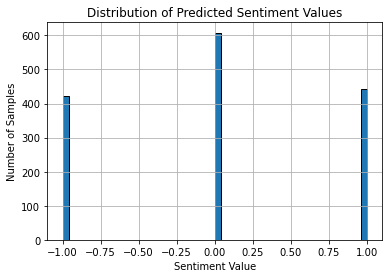

In [138]:
# Plotting the histogram for predicted values
plt.hist(fn_senti_wv['Dominant_Sentiment'], bins=50, edgecolor='black')
plt.title('Distribution of Predicted Sentiment Values')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

In [139]:
#save the results in pickle 

with open ("fn_senti_wv.pkl", "wb") as file:
    pickle.dump(fn_senti_wv, file)

# Senti Analysis 2 
# FinBERT on financial_phrasebank dataset

In [27]:
financial_phrasebank = load_dataset('financial_phrasebank', 'sentences_allagree')
financial_phrasebank

financial_phrasebank_df = dataset['train']
financial_phrasebank_df = pd.DataFrame(financial_phrasebank_df)
financial_phrasebank_df

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2
...,...,...
2259,Operating result for the 12-month period decre...,0
2260,HELSINKI Thomson Financial - Shares in Cargote...,0
2261,LONDON MarketWatch -- Share prices ended lower...,0
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0


In [54]:
# model

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

FinBERT_pipeline = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)
finbert

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [29]:
results = []
def predict(sent):
  try:
    result = FinBERT_pipeline(sent)
    results.append(result)
  except:
    results.append('')


In [30]:
financial_phrasebank_df['predicted'] = financial_phrasebank_df['sentence'].apply(lambda x: predict(x))
financial_phrasebank_df

,sentence,label,predicted
0,"According to Gran , the company has no plans t...",1,None
1,"For the last quarter of 2010 , Componenta 's n...",2,None
2,"In the third quarter of 2010 , net sales incre...",2,None
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,None
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,None
...,...,...,...
2259,Operating result for the 12-month period decre...,0,None
2260,HELSINKI Thomson Financial - Shares in Cargote...,0,None
2261,LONDON MarketWatch -- Share prices ended lower...,0,None
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0,None


In [31]:
financial_phrasebank_df['predicted'] = results
financial_phrasebank_df

,sentence,label,predicted
0,"According to Gran , the company has no plans t...",1,"[{'label': 'Neutral', 'score': 0.9999823570251..."
1,"For the last quarter of 2010 , Componenta 's n...",2,"[{'label': 'Positive', 'score': 0.999999880790..."
2,"In the third quarter of 2010 , net sales incre...",2,"[{'label': 'Positive', 'score': 0.999999523162..."
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,"[{'label': 'Positive', 'score': 0.999991893768..."
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,"[{'label': 'Positive', 'score': 0.994542181491..."
...,...,...,...
2259,Operating result for the 12-month period decre...,0,"[{'label': 'Negative', 'score': 0.999969005584..."
2260,HELSINKI Thomson Financial - Shares in Cargote...,0,"[{'label': 'Negative', 'score': 0.999999165534..."
2261,LONDON MarketWatch -- Share prices ended lower...,0,"[{'label': 'Negative', 'score': 0.999972462654..."
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0,"[{'label': 'Negative', 'score': 0.999522924423..."


In [32]:
financial_phrasebank_df['predicted'][0]

[{'label': 'Neutral', 'score': 0.9999823570251465}]

In [33]:
output = []
for result in results:
  out = result[0]['label']
  if out == 'Neutral':
    output.append(1)
  if out == 'Positive':
    output.append(2)
  if out == 'Negative':
    output.append(0)

In [34]:
financial_phrasebank_df['predicted_label'] = output
financial_phrasebank_df

,sentence,label,predicted,predicted_label
0,"According to Gran , the company has no plans t...",1,"[{'label': 'Neutral', 'score': 0.9999823570251...",1
1,"For the last quarter of 2010 , Componenta 's n...",2,"[{'label': 'Positive', 'score': 0.999999880790...",2
2,"In the third quarter of 2010 , net sales incre...",2,"[{'label': 'Positive', 'score': 0.999999523162...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,"[{'label': 'Positive', 'score': 0.999991893768...",2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,"[{'label': 'Positive', 'score': 0.994542181491...",2
...,...,...,...,...
2259,Operating result for the 12-month period decre...,0,"[{'label': 'Negative', 'score': 0.999969005584...",0
2260,HELSINKI Thomson Financial - Shares in Cargote...,0,"[{'label': 'Negative', 'score': 0.999999165534...",0
2261,LONDON MarketWatch -- Share prices ended lower...,0,"[{'label': 'Negative', 'score': 0.999972462654...",0
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0,"[{'label': 'Negative', 'score': 0.999522924423...",0


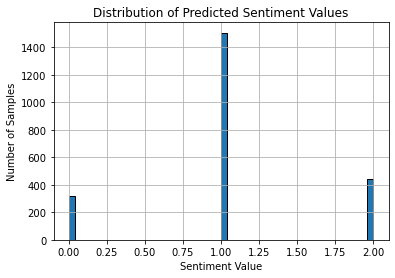

In [55]:
# Plotting the histogram for predicted values
plt.hist(financial_phrasebank_df['predicted_label'], bins=50, edgecolor='black')
plt.title('Distribution of Predicted Sentiment Values')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

accuracy : 0.9169611307420494
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       303
           1       0.91      0.99      0.95      1391
           2       0.96      0.74      0.84       570

    accuracy                           0.92      2264
   macro avg       0.92      0.89      0.90      2264
weighted avg       0.92      0.92      0.91      2264



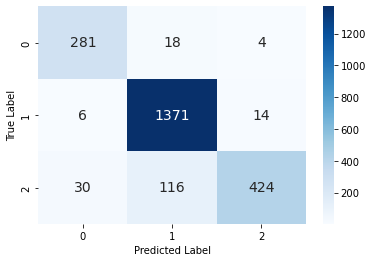

In [35]:
# performance metrics of the Model:

y_test_final = financial_phrasebank_df['label']
test_pred = financial_phrasebank_df['predicted_label']

# Test accuracy
accuracy = accuracy_score(y_test_final, test_pred)
print ('accuracy :', accuracy)

# per metrics
print(classification_report(y_test_final, test_pred))

# Test - confusion matrix
cm = confusion_matrix(y_test_final, test_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', annot_kws={"fontsize":14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# NOTE: 
The accuracy of Senti Analysis 2 - FinBERT on financial_phrasebank dataset is 92% better than Bi-LSTM with word2vec which is 87%

# Senti Analysis 2.1 - FinBERT on NYT dataset

In [140]:
# NYT dataset
NYT_dataset = AAPL_filtered_df.copy()
NYT_dataset

,Pub Date,Headline+abstract
6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O..."
5,2013-01-03,Tip of the Week: How to Control the Music in i...
4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...
1,2013-01-07,Providing a Template to Challenge Apple : Medi...
2,2013-01-09,Q&A: Making the Mac Take Dictation : The built...
...,...,...
3958,2023-07-05,"Popcast (Deluxe): Olivia Rodrigo Returns, Fall..."
3954,2023-07-06,"America, Shall I Compare Thee to a Chevy Volt?..."
3953,2023-07-10,"This MacBook Air Is $200 Off for Prime Day, th..."
3965,2023-07-11,The 23 Best Apple Deals of Amazon Prime Day 20...


In [141]:
# model

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

FinBERT_pipeline = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)


In [142]:
results = []
def predict(sent):
  try:
    result = FinBERT_pipeline(sent)
    results.append(result)
  except:
    results.append('')


In [143]:
NYT_dataset['predicted'] = NYT_dataset['Headline+abstract'].apply(lambda x: predict(x))
NYT_dataset

,Pub Date,Headline+abstract,predicted
6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O...",None
5,2013-01-03,Tip of the Week: How to Control the Music in i...,None
4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...,None
1,2013-01-07,Providing a Template to Challenge Apple : Medi...,None
2,2013-01-09,Q&A: Making the Mac Take Dictation : The built...,None
...,...,...,...
3958,2023-07-05,"Popcast (Deluxe): Olivia Rodrigo Returns, Fall...",None
3954,2023-07-06,"America, Shall I Compare Thee to a Chevy Volt?...",None
3953,2023-07-10,"This MacBook Air Is $200 Off for Prime Day, th...",None
3965,2023-07-11,The 23 Best Apple Deals of Amazon Prime Day 20...,None


In [144]:
NYT_dataset['predicted'] = results
NYT_dataset

,Pub Date,Headline+abstract,predicted
6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O...","[{'label': 'Negative', 'score': 0.619303107261..."
5,2013-01-03,Tip of the Week: How to Control the Music in i...,"[{'label': 'Neutral', 'score': 0.9998842477798..."
4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...,"[{'label': 'Negative', 'score': 0.990723431110..."
1,2013-01-07,Providing a Template to Challenge Apple : Medi...,"[{'label': 'Neutral', 'score': 0.9037889838218..."
2,2013-01-09,Q&A: Making the Mac Take Dictation : The built...,"[{'label': 'Neutral', 'score': 0.9999886751174..."
...,...,...,...
3958,2023-07-05,"Popcast (Deluxe): Olivia Rodrigo Returns, Fall...","[{'label': 'Neutral', 'score': 0.9998999834060..."
3954,2023-07-06,"America, Shall I Compare Thee to a Chevy Volt?...","[{'label': 'Neutral', 'score': 0.9999295473098..."
3953,2023-07-10,"This MacBook Air Is $200 Off for Prime Day, th...","[{'label': 'Positive', 'score': 0.999999284744..."
3965,2023-07-11,The 23 Best Apple Deals of Amazon Prime Day 20...,"[{'label': 'Neutral', 'score': 0.8607615232467..."


In [145]:
NYT_dataset['predicted'][1]

[{'label': 'Neutral', 'score': 0.9037889838218689}]

In [146]:
# Extract 'label' and 'score' and create new columns
NYT_dataset['Sentiment'] = NYT_dataset['predicted'].apply(lambda x: x[0]['label'])
NYT_dataset['Sentiment'] = NYT_dataset['Sentiment'].replace({'Negative': 0, 'Neutral': 1, 'Positive': 2})
NYT_dataset['Senti_Score'] = NYT_dataset['predicted'].apply(lambda x: x[0]['score'])
NYT_dataset

,Pub Date,Headline+abstract,predicted,Sentiment,Senti_Score
6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O...","[{'label': 'Negative', 'score': 0.619303107261...",0,0.619303
5,2013-01-03,Tip of the Week: How to Control the Music in i...,"[{'label': 'Neutral', 'score': 0.9998842477798...",1,0.999884
4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...,"[{'label': 'Negative', 'score': 0.990723431110...",0,0.990723
1,2013-01-07,Providing a Template to Challenge Apple : Medi...,"[{'label': 'Neutral', 'score': 0.9037889838218...",1,0.903789
2,2013-01-09,Q&A: Making the Mac Take Dictation : The built...,"[{'label': 'Neutral', 'score': 0.9999886751174...",1,0.999989
...,...,...,...,...,...
3958,2023-07-05,"Popcast (Deluxe): Olivia Rodrigo Returns, Fall...","[{'label': 'Neutral', 'score': 0.9998999834060...",1,0.999900
3954,2023-07-06,"America, Shall I Compare Thee to a Chevy Volt?...","[{'label': 'Neutral', 'score': 0.9999295473098...",1,0.999930
3953,2023-07-10,"This MacBook Air Is $200 Off for Prime Day, th...","[{'label': 'Positive', 'score': 0.999999284744...",2,0.999999
3965,2023-07-11,The 23 Best Apple Deals of Amazon Prime Day 20...,"[{'label': 'Neutral', 'score': 0.8607615232467...",1,0.860762


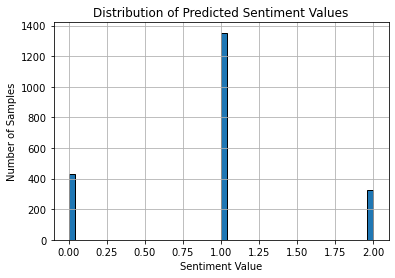

In [147]:
# Plotting the histogram for predicted values
plt.hist(NYT_dataset['Sentiment'], bins=50, edgecolor='black')
plt.title('Distribution of Predicted Sentiment Values')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

# NOTE: 
The Senti Analysis 2.1 - FinBERT on NYT dataset is done. 

# Now merge the sentiments against the dates and make it ready for the main analysis(i.e. stock price prediciton)

In [148]:
# Create new results_df with Pub Date and the sentiment values
results_df_finBERT = pd.DataFrame({
    'Pub Date': AAPL_filtered_df['Pub Date'],
    'Headline+abstract': AAPL_filtered_df['Headline+abstract'] ,
    'Sentiment': NYT_dataset['Sentiment'],
    'Senti Score': NYT_dataset['Senti_Score']
})
results_df_finBERT

,Pub Date,Headline+abstract,Sentiment,Senti Score
6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O...",0,0.619303
5,2013-01-03,Tip of the Week: How to Control the Music in i...,1,0.999884
4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...,0,0.990723
1,2013-01-07,Providing a Template to Challenge Apple : Medi...,1,0.903789
2,2013-01-09,Q&A: Making the Mac Take Dictation : The built...,1,0.999989
...,...,...,...,...
3958,2023-07-05,"Popcast (Deluxe): Olivia Rodrigo Returns, Fall...",1,0.999900
3954,2023-07-06,"America, Shall I Compare Thee to a Chevy Volt?...",1,0.999930
3953,2023-07-10,"This MacBook Air Is $200 Off for Prime Day, th...",2,0.999999
3965,2023-07-11,The 23 Best Apple Deals of Amazon Prime Day 20...,1,0.860762


In [149]:
duplicates = results_df_finBERT[results_df_finBERT['Pub Date'].duplicated(keep=False)]
duplicates

,Pub Date,Headline+abstract,Sentiment,Senti Score
19,2013-01-14,Google Gains From Creating Apps for the Opposi...,2,1.000000
17,2013-01-14,Daily Report: Google Invades the iPhone : For ...,1,0.991008
12,2013-01-17,AT&T Allows FaceTime for Limited Data Users. W...,1,0.999904
10,2013-01-17,Digital Notes: Amazon Enters Apple’s Phones to...,1,0.999135
20,2013-01-24,"For Investors, Apple Not as Shiny : The Times'...",1,0.837984
...,...,...,...,...
3914,2023-05-22,Companies Are Taking a Harder Line on Union Or...,0,0.569615
3922,2023-06-06,Can Apple Take the Metaverse Mainstream? : The...,2,0.999465
3925,2023-06-06,Why I Can’t Bet Against Apple’s Mixed-Reality ...,1,0.622169
3926,2023-06-06,"A First Try of Apple’s $3,500 Vision Pro Heads...",1,0.978871


In [150]:
# keeping the date column unique and moving the 2nd, 3rd ... news of the same day to separate columns 
#(this is done to ease the merge with the fundamental data)

# Placeholder for the new dataframe's data
new_data = []

# Grouping by 'Pub Date'
grouped = results_df_finBERT.groupby('Pub Date')

# Iterate over each group
for date, group in grouped:
    # Create a temporary dictionary to hold this group's data
    temp = {'Pub Date': date}
    
    # Iterate over the rows in the group
    for idx, row in enumerate(group.iterrows()):
        if idx == 0:
            temp['Sentiment_1'] = row[1]['Sentiment']
            temp['Senti_Score_1'] = row[1]['Senti Score']
        else:
            temp[f'Sentiment_{idx + 1}'] = row[1]['Sentiment']
            temp[f'Senti_Score_{idx + 1}'] = row[1]['Senti Score']
    
    new_data.append(temp)

# Convert the list of dictionaries to a DataFrame
results_df_finBERT = pd.DataFrame(new_data)
results_df_finBERT

,Pub Date,Sentiment_1,Senti_Score_1,Sentiment_2,Senti_Score_2,Sentiment_3,Senti_Score_3,Sentiment_4,Senti_Score_4,Sentiment_5,Senti_Score_5,Sentiment_6,Senti_Score_6
0,2013-01-02,0,0.619303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,1,0.999884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,0,0.990723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,1,0.903789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-09,1,0.999989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,2023-07-05,1,0.999900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1470,2023-07-06,1,0.999930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1471,2023-07-10,2,0.999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1472,2023-07-11,1,0.860762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
results_df_finBERT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1474 entries, 0 to 1473
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pub Date       1474 non-null   object 
 1   Sentiment_1    1474 non-null   int64  
 2   Senti_Score_1  1474 non-null   float64
 3   Sentiment_2    451 non-null    float64
 4   Senti_Score_2  451 non-null    float64
 5   Sentiment_3    133 non-null    float64
 6   Senti_Score_3  133 non-null    float64
 7   Sentiment_4    43 non-null     float64
 8   Senti_Score_4  43 non-null     float64
 9   Sentiment_5    10 non-null     float64
 10  Senti_Score_5  10 non-null     float64
 11  Sentiment_6    2 non-null      float64
 12  Senti_Score_6  2 non-null      float64
dtypes: float64(11), int64(1), object(1)
memory usage: 149.8+ KB


In [152]:
no_nan_rows = results_df_finBERT.dropna()
no_nan_rows

,Pub Date,Sentiment_1,Senti_Score_1,Sentiment_2,Senti_Score_2,Sentiment_3,Senti_Score_3,Sentiment_4,Senti_Score_4,Sentiment_5,Senti_Score_5,Sentiment_6,Senti_Score_6
122,2013-09-10,1,0.999990,1.0,0.990053,0.0,0.999960,2.0,0.999989,1.0,0.998950,1.0,0.998647
621,2016-08-31,0,0.996815,1.0,0.997763,1.0,0.992772,1.0,0.994681,1.0,0.999975,1.0,0.998333


In [153]:
# This is to have one dominant sentiment for a day, because most of the rows are having 2 to 3 news.

# Create new columns for counts of 0s, 1s, and 2s
results_df_finBERT['Count_0'] = 0
results_df_finBERT['Count_1'] = 0
results_df_finBERT['Count_2'] = 0

# Iterate over rows
for idx, row in results_df_finBERT.iterrows():
    # Extract sentiment columns
    sentiments = [row[f'Sentiment_{i}'] for i in range(1, 7) if not np.isnan(row[f'Sentiment_{i}'])]
    
    # Count 0s, 1s, and 2s
    count_0 = sentiments.count(0)
    count_1 = sentiments.count(1)
    count_2 = sentiments.count(2)
    
    # Assign counts to respective columns
    results_df_finBERT.at[idx, 'Count_0'] = count_0
    results_df_finBERT.at[idx, 'Count_1'] = count_1
    results_df_finBERT.at[idx, 'Count_2'] = count_2

    # Set initial dominant sentiment based on counts
    if count_0 > count_1 and count_0 > count_2:
        results_df_finBERT.at[idx, 'Dominant_Sentiment'] = 0
    elif count_1 > count_0 and count_1 > count_2:
        results_df_finBERT.at[idx, 'Dominant_Sentiment'] = 1
    elif count_2 > count_0 and count_2 > count_1:
        results_df_finBERT.at[idx, 'Dominant_Sentiment'] = 2

    # Check conditions
    else:
        if count_0 == count_1:
            results_df_finBERT.at[idx, 'Dominant_Sentiment'] = 0
        elif count_2 == count_1:
            results_df_finBERT.at[idx, 'Dominant_Sentiment'] = 2
        elif count_0 == count_2:
            # Extract senti_score
            senti_scores = [row[f'Senti_Score_{i}'] for i in range(1, 7) if not np.isnan(row[f'Senti_Score_{i}'])]

            # Find the sentiment with the maximum senti_score
            max_senti_score = max(senti_scores)

            for i in range(1, 7):
                if row[f'Senti_Score_{i}'] == max_senti_score:
                    results_df_finBERT.at[idx, 'Dominant_Sentiment'] = row[f'Sentiment_{i}']
                    break
results_df_finBERT.head(60)

,Pub Date,Sentiment_1,Senti_Score_1,Sentiment_2,Senti_Score_2,Sentiment_3,Senti_Score_3,Sentiment_4,Senti_Score_4,Sentiment_5,Senti_Score_5,Sentiment_6,Senti_Score_6,Count_0,Count_1,Count_2,Dominant_Sentiment
0,2013-01-02,0,0.619303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0.0
1,2013-01-03,1,0.999884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
2,2013-01-04,0,0.990723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0.0
3,2013-01-07,1,0.903789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
4,2013-01-09,1,0.999989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
5,2013-01-10,2,0.844982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
6,2013-01-13,1,0.923442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
7,2013-01-14,2,1.000000,1.0,0.991008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,2.0
8,2013-01-15,1,0.871877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
9,2013-01-16,1,0.999930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0


In [154]:
equal_counts_df = results_df_finBERT[results_df_finBERT['Count_0'] == results_df_finBERT['Count_1']]
equal_counts_df

,Pub Date,Sentiment_1,Senti_Score_1,Sentiment_2,Senti_Score_2,Sentiment_3,Senti_Score_3,Sentiment_4,Senti_Score_4,Sentiment_5,Senti_Score_5,Sentiment_6,Senti_Score_6,Count_0,Count_1,Count_2,Dominant_Sentiment
5,2013-01-10,2,0.844982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
19,2013-02-07,2,0.999969,0.0,0.996286,1.0,0.999975,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,0.0
29,2013-02-25,2,0.981665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
32,2013-03-01,2,0.865297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
39,2013-03-15,2,0.850909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,2023-04-18,2,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
1453,2023-05-04,2,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
1463,2023-06-07,2,0.931785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
1467,2023-06-27,2,0.998955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0


In [155]:
#Store the date and sentiment in a separate df to send it to the main analysis.

fn_senti_finbert = results_df_finBERT[['Pub Date', 'Dominant_Sentiment']].copy()
fn_senti_finbert['Dominant_Sentiment'] = fn_senti_finbert['Dominant_Sentiment'].replace({0: -1, 1: 0, 2: 1})
fn_senti_finbert = fn_senti_finbert.rename(columns={'Pub Date' : 'Date'})
fn_senti_finbert['Date'] = pd.to_datetime(fn_senti_finbert['Date'])
fn_senti_finbert

,Date,Dominant_Sentiment
0,2013-01-02,-1.0
1,2013-01-03,0.0
2,2013-01-04,-1.0
3,2013-01-07,0.0
4,2013-01-09,0.0
...,...,...
1469,2023-07-05,0.0
1470,2023-07-06,0.0
1471,2023-07-10,1.0
1472,2023-07-11,0.0


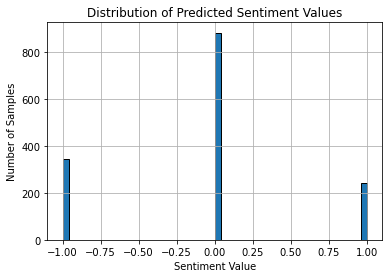

In [156]:
# Plotting the histogram for predicted values
plt.hist(fn_senti_finbert['Dominant_Sentiment'], bins=50, edgecolor='black')
plt.title('Distribution of Predicted Sentiment Values')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

In [157]:
#save the results in pickle 
import pickle

with open ("fn_senti_finbert.pkl", "wb") as file:
    pickle.dump(fn_senti_finbert, file)

# Senti Analysis 3 - LLM on financial_phrasebank dataset

tried using chatGPT3.5 LLM model to predict the sentiment of financial_phrasebank dataset to compare it with other models

In [56]:
openai.api_key= "need to put my API-key here, since it's chargable I have hidden this"


In [57]:
# principle 1
def agent(prompt,model="gpt-3.5-turbo"):
  messages = [{"role":"user", "content":prompt}]
  try:
    response = openai.ChatCompletion.create(
      model = model,
      messages = messages,
      temperature = 0
    )
    return response.choices[0].message["content"]
  except:
    response = None
    return response

In [58]:
financial_phrasebank = load_dataset('financial_phrasebank', 'sentences_allagree')
financial_phrasebank_df_gpt = dataset['train']
financial_phrasebank_df_gpt = pd.DataFrame(financial_phrasebank_df_gpt)
financial_phrasebank_df_gpt

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2
...,...,...
2259,Operating result for the 12-month period decre...,0
2260,HELSINKI Thomson Financial - Shares in Cargote...,0
2261,LONDON MarketWatch -- Share prices ended lower...,0
2262,Operating profit fell to EUR 35.4 mn from EUR ...,0


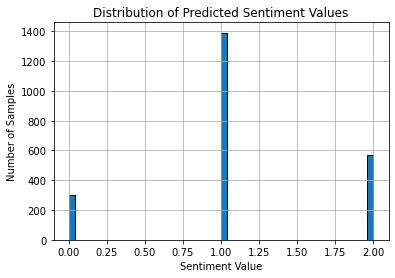

In [59]:
# Plotting the histogram for predicted values
plt.hist(financial_phrasebank_df_gpt['label'], bins=50, edgecolor='black')
plt.title('Distribution of Predicted Sentiment Values')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

In [60]:
#prompt

results = []
def predict(sent):
  prompt = f"""You are a financial analyst. Your job is to analyze news headlines and predict whether the sentiment is Positive, Negative, or Neutral.

    When analyzing each headline:

    - Consider the financial implications mentioned in the text.
    - Take into account any specific figures or percentages that might indicate financial growth or decline.
    - Consider the context of the words: does the headline hint at positive developments, negative outcomes, or is it simply conveying information without a particular positive or negative slant?
    - Remember to stay neutral and base your analysis solely on the information presented in the headline, without external bias or knowledge.

    Please read each headline and respond with 'Positive', 'Negative', or 'Neutral' to indicate the overall sentiment.

    Example 1:
    Headline: 'Sales in Finland decreased by 10.5 % in January , while sales outside Finland dropped by 17 % .'
    Sentiment: 'Negative'

    Example 2:
    Headline: 'The mall is part of the Baltic Pearl development project in the city of St Petersburg , where Baltic Pearl CJSC , a subsidiary of Shanghai Foreign Joint Investment Company , is developing homes for 35,000 people .'
    Sentiment: 'Neutral'

    Example 3:
    Headline: 'Marathon estimates the value of its remaining stake in Protalix at $ 27 million .'
    Sentiment: 'Neutral'
    
    Example 4:
    Headline: 'The investment will be worth approximately EUR 100mn .'
    Sentiment: 'Neutral'
    
    Example 5:
    Headline: 'Turun kaupunkin , Finland based company has awarded contract to Lemminkainen Talotekniikka Oy for electrical installation work .'
    Sentiment: 'Positive'
    
    Example 6:
    Headline: 'Arvo Vuorenmaa , the Loviisa plant 's general manager said the application for the new licence was a `` standard '' procedure and that he was `` quite confident '' about approval being granted .'
    Sentiment: 'Positive'
    
    Example 7:
    Headline: 'The group 's 12-month operating profit grew 31 percent to 337.8 million euros .'
    Sentiment: 'Positive'
    

    Headline: \"\"\"{sent}\"\"\"
    Sentiment:
    """

  try:
    result = agent(prompt)
    results.append(result)
  except:
    pass
  return result

In [61]:
# to predict - I have commented this code beacause it's connect to my account with API which is chargable
#financial_phrasebank_df_gpt['predicted'] = financial_phrasebank_df_gpt['sentence'].apply(lambda x: predict(x))


In [62]:
results

[]

In [63]:
numpy_array = np.array(results)
numpy_array

array([], dtype=float64)

In [64]:
#save the file for a safety - The results stored should not be chaged, so commented this even.
#financial_phrasebank_df_gpt.to_csv('ChatGPT3.5_senti_financial_phrasebank_data.csv', index=True)

In [65]:
#Again pulling the csv
financial_phrasebank_df_gpt = pd.read_csv('ChatGPT3.5_senti_financial_phrasebank_data.csv')
financial_phrasebank_df_gpt

,Unnamed: 0,sentence,label,predicted
0,0,"According to Gran , the company has no plans t...",1,1.0
1,1,"For the last quarter of 2010 , Componenta 's n...",2,2.0
2,2,"In the third quarter of 2010 , net sales incre...",2,2.0
3,3,Operating profit rose to EUR 13.1 mn from EUR ...,2,2.0
4,4,"Operating profit totalled EUR 21.1 mn , up fro...",2,2.0
...,...,...,...,...
2259,2259,Operating result for the 12-month period decre...,0,0.0
2260,2260,HELSINKI Thomson Financial - Shares in Cargote...,0,0.0
2261,2261,LONDON MarketWatch -- Share prices ended lower...,0,0.0
2262,2262,Operating profit fell to EUR 35.4 mn from EUR ...,0,0.0


In [66]:
#remove NaNs
rows_with_na12 = financial_phrasebank_df_gpt[financial_phrasebank_df_gpt.isna().any(axis=1)]
rows_with_na12


,Unnamed: 0,sentence,label,predicted
1580,1580,The profit after taxes was EUR 57.7 11.1 milli...,1,NaN
1842,1842,The Web-Marela application handles invitations...,1,NaN
1989,1989,`` We have a license agreement with Nokia Corp...,1,NaN


In [67]:

# Identify indices of rows with NaN values
indices_to_drop = rows_with_na12.index

# Drop these rows with NaN
financial_phrasebank_df_gpt = financial_phrasebank_df_gpt.drop(indices_to_drop)
financial_phrasebank_df_gpt

,Unnamed: 0,sentence,label,predicted
0,0,"According to Gran , the company has no plans t...",1,1.0
1,1,"For the last quarter of 2010 , Componenta 's n...",2,2.0
2,2,"In the third quarter of 2010 , net sales incre...",2,2.0
3,3,Operating profit rose to EUR 13.1 mn from EUR ...,2,2.0
4,4,"Operating profit totalled EUR 21.1 mn , up fro...",2,2.0
...,...,...,...,...
2259,2259,Operating result for the 12-month period decre...,0,0.0
2260,2260,HELSINKI Thomson Financial - Shares in Cargote...,0,0.0
2261,2261,LONDON MarketWatch -- Share prices ended lower...,0,0.0
2262,2262,Operating profit fell to EUR 35.4 mn from EUR ...,0,0.0


accuracy : 0.9221583370190182
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       303
           1       0.96      0.94      0.95      1388
           2       0.87      0.85      0.86       570

    accuracy                           0.92      2261
   macro avg       0.90      0.92      0.91      2261
weighted avg       0.92      0.92      0.92      2261



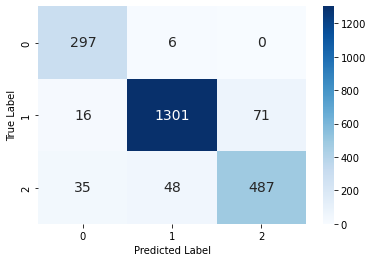

In [68]:
# performance metrics of the Model:

y_test_final = financial_phrasebank_df_gpt['label']
test_pred = financial_phrasebank_df_gpt['predicted']

# Test accuracy
accuracy = accuracy_score(y_test_final, test_pred)
print ('accuracy :', accuracy)

# per metrics
print(classification_report(y_test_final, test_pred))

# Test - confusion matrix
cm = confusion_matrix(y_test_final, test_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', annot_kws={"fontsize":14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

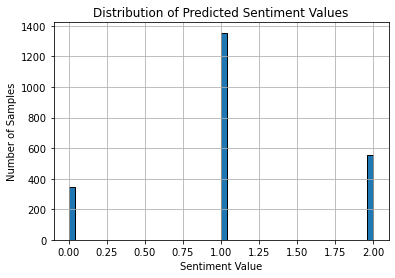

In [69]:
# Plotting the histogram for predicted values
plt.hist(financial_phrasebank_df_gpt['predicted'], bins=50, edgecolor='black')
plt.title('Distribution of Predicted Sentiment Values')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

# Senti Analysis 3.1 - LLM on NewYork Times dataset

In [88]:
# NYT dataset
NYT_dataset_gpt = AAPL_filtered_df.copy()
NYT_dataset_gpt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2113 entries, 6 to 3972
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Pub Date           2113 non-null   object
 1   Headline+abstract  2113 non-null   object
dtypes: object(2)
memory usage: 114.1+ KB


In [89]:
NYT_dataset_gpt

,Pub Date,Headline+abstract
6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O..."
5,2013-01-03,Tip of the Week: How to Control the Music in i...
4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...
1,2013-01-07,Providing a Template to Challenge Apple : Medi...
2,2013-01-09,Q&A: Making the Mac Take Dictation : The built...
...,...,...
3958,2023-07-05,"Popcast (Deluxe): Olivia Rodrigo Returns, Fall..."
3954,2023-07-06,"America, Shall I Compare Thee to a Chevy Volt?..."
3953,2023-07-10,"This MacBook Air Is $200 Off for Prime Day, th..."
3965,2023-07-11,The 23 Best Apple Deals of Amazon Prime Day 20...


In [90]:
#prompt

results = []
def predict(sent):
  prompt = f"""You are a financial analyst. Your job is to analyze news headlines and predict whether the sentiment is Positive, Negative, or Neutral.

    When analyzing each headline:

    - Consider the financial implications mentioned in the text.
    - Take into account any specific figures or percentages that might indicate financial growth or decline.
    - Consider the context of the words: does the headline hint at positive developments, negative outcomes, or is it simply conveying information without a particular positive or negative slant?
    - Remember to stay neutral and base your analysis solely on the information presented in the headline, without external bias or knowledge.

    Please read each headline and respond with 'Positive', 'Negative', or 'Neutral' to indicate the overall sentiment.

    Example 1:
    Headline: 'Sales in Finland decreased by 10.5 % in January , while sales outside Finland dropped by 17 % .'
    Sentiment: 'Negative'

    Example 2:
    Headline: 'The mall is part of the Baltic Pearl development project in the city of St Petersburg , where Baltic Pearl CJSC , a subsidiary of Shanghai Foreign Joint Investment Company , is developing homes for 35,000 people .'
    Sentiment: 'Neutral'

    Example 3:
    Headline: 'Marathon estimates the value of its remaining stake in Protalix at $ 27 million .'
    Sentiment: 'Neutral'
    
    Example 4:
    Headline: 'The investment will be worth approximately EUR 100mn .'
    Sentiment: 'Neutral'
    
    Example 5:
    Headline: 'Turun kaupunkin , Finland based company has awarded contract to Lemminkainen Talotekniikka Oy for electrical installation work .'
    Sentiment: 'Positive'
    
    Example 6:
    Headline: 'Arvo Vuorenmaa , the Loviisa plant 's general manager said the application for the new licence was a `` standard '' procedure and that he was `` quite confident '' about approval being granted .'
    Sentiment: 'Positive'
    
    Example 7:
    Headline: 'The group 's 12-month operating profit grew 31 percent to 337.8 million euros .'
    Sentiment: 'Positive'
    

    Headline: \"\"\"{sent}\"\"\"
    Sentiment:
    """

  try:
    result = agent(prompt)
    results.append(result)
  except:
    pass
  return result

In [91]:
#predict
#NYT_dataset_gpt['predicted'] = NYT_dataset_gpt['Headline+abstract'].apply(lambda x: predict(x))


In [92]:
results

[]

In [93]:
numpy_array = np.array(results)
numpy_array

array([], dtype=float64)

In [94]:
#NYT_dataset_gpt['predicted']= NYT_dataset_gpt['predicted'].replace({'Negative': 0, 'Neutral': 1, 'Positive': 2})
#NYT_dataset_gpt

In [95]:
#save the file for a safety
#NYT_dataset_gpt.to_csv('ChatGPT3.5_senti_NYTdata.csv', index=True)

In [96]:
#Again pulling the csv
NYT_dataset_gpt = pd.read_csv('ChatGPT3.5_senti_NYTdata.csv')
NYT_dataset_gpt

,Unnamed: 0,Pub Date,Headline+abstract,predicted
0,6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O...",0.0
1,5,2013-01-03,Tip of the Week: How to Control the Music in i...,1.0
2,4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...,0.0
3,1,2013-01-07,Providing a Template to Challenge Apple : Medi...,2.0
4,2,2013-01-09,Q&A: Making the Mac Take Dictation : The built...,1.0
...,...,...,...,...
2108,3958,2023-07-05,"Popcast (Deluxe): Olivia Rodrigo Returns, Fall...",1.0
2109,3954,2023-07-06,"America, Shall I Compare Thee to a Chevy Volt?...",1.0
2110,3953,2023-07-10,"This MacBook Air Is $200 Off for Prime Day, th...",2.0
2111,3965,2023-07-11,The 23 Best Apple Deals of Amazon Prime Day 20...,1.0


In [97]:
#remove NaNs
rows_with_na12 = NYT_dataset_gpt[NYT_dataset_gpt.isna().any(axis=1)]
rows_with_na12


,Unnamed: 0,Pub Date,Headline+abstract,predicted
1790,3174,2021-05-10,Stay Safe From App Tracking : What we can lear...,NaN


In [98]:

# Identify indices of rows with NaN values
indices_to_drop = rows_with_na12.index

# Drop these rows with NaN
NYT_dataset_gpt = NYT_dataset_gpt.drop(indices_to_drop)
NYT_dataset_gpt

,Unnamed: 0,Pub Date,Headline+abstract,predicted
0,6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O...",0.0
1,5,2013-01-03,Tip of the Week: How to Control the Music in i...,1.0
2,4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...,0.0
3,1,2013-01-07,Providing a Template to Challenge Apple : Medi...,2.0
4,2,2013-01-09,Q&A: Making the Mac Take Dictation : The built...,1.0
...,...,...,...,...
2108,3958,2023-07-05,"Popcast (Deluxe): Olivia Rodrigo Returns, Fall...",1.0
2109,3954,2023-07-06,"America, Shall I Compare Thee to a Chevy Volt?...",1.0
2110,3953,2023-07-10,"This MacBook Air Is $200 Off for Prime Day, th...",2.0
2111,3965,2023-07-11,The 23 Best Apple Deals of Amazon Prime Day 20...,1.0


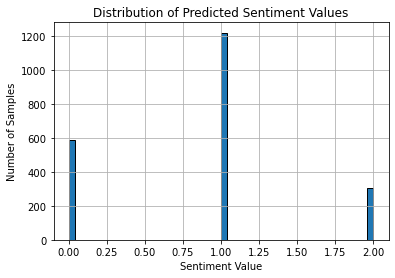

In [99]:
# Plotting the histogram for predicted values
plt.hist(NYT_dataset_gpt['predicted'], bins=50, edgecolor='black')
plt.title('Distribution of Predicted Sentiment Values')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

# NOTE: 
The Senti Analysis 3.1 - ChatGPT-3.5 LLM on NYT dataset is done. 

# Now merge the sentiments against the dates and make it ready for the main analysis(i.e. stock price prediciton)

In [100]:
# Create new results_df with Pub Date and the sentiment values
results_df_chatGPT = NYT_dataset_gpt.copy()
results_df_chatGPT['predicted'] = results_df_chatGPT['predicted'].astype('Int64', errors='raise')
results_df_chatGPT

,Unnamed: 0,Pub Date,Headline+abstract,predicted
0,6,2013-01-02,"The iPhone Goofs Up on Telling Time, Again : O...",0
1,5,2013-01-03,Tip of the Week: How to Control the Music in i...,1
2,4,2013-01-04,Inquiry Into Tech Giants’ Tax Strategies Nears...,0
3,1,2013-01-07,Providing a Template to Challenge Apple : Medi...,2
4,2,2013-01-09,Q&A: Making the Mac Take Dictation : The built...,1
...,...,...,...,...
2108,3958,2023-07-05,"Popcast (Deluxe): Olivia Rodrigo Returns, Fall...",1
2109,3954,2023-07-06,"America, Shall I Compare Thee to a Chevy Volt?...",1
2110,3953,2023-07-10,"This MacBook Air Is $200 Off for Prime Day, th...",2
2111,3965,2023-07-11,The 23 Best Apple Deals of Amazon Prime Day 20...,1


In [101]:
duplicates = results_df_chatGPT[results_df_chatGPT['Pub Date'].duplicated(keep=False)]
duplicates

,Unnamed: 0,Pub Date,Headline+abstract,predicted
7,19,2013-01-14,Google Gains From Creating Apps for the Opposi...,1
8,17,2013-01-14,Daily Report: Google Invades the iPhone : For ...,1
11,12,2013-01-17,AT&T Allows FaceTime for Limited Data Users. W...,0
12,10,2013-01-17,Digital Notes: Amazon Enters Apple’s Phones to...,1
15,20,2013-01-24,"For Investors, Apple Not as Shiny : The Times'...",0
...,...,...,...,...
2094,3914,2023-05-22,Companies Are Taking a Harder Line on Union Or...,0
2098,3922,2023-06-06,Can Apple Take the Metaverse Mainstream? : The...,2
2099,3925,2023-06-06,Why I Can’t Bet Against Apple’s Mixed-Reality ...,1
2100,3926,2023-06-06,"A First Try of Apple’s $3,500 Vision Pro Heads...",1


In [102]:
# keeping the date column unique and moving the 2nd, 3rd ... news of the same day to separate columns 
#(this is done to ease the merge with the fundamental data)

# Placeholder for the new dataframe's data
new_data = []

# Grouping by 'Pub Date'
grouped = results_df_chatGPT.groupby('Pub Date')

# Iterate over each group
for date, group in grouped:
    # Create a temporary dictionary to hold this group's data
    temp = {'Pub Date': date}
    
    # Iterate over the rows in the group
    for idx, row in enumerate(group.iterrows()):
        if idx == 0:
            temp['predicted_1'] = row[1]['predicted']
        else:
            temp[f'predicted_{idx + 1}'] = row[1]['predicted']
    
    new_data.append(temp)

# Convert the list of dictionaries to a DataFrame
results_df_chatGPT = pd.DataFrame(new_data)
results_df_chatGPT

,Pub Date,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6
0,2013-01-02,0,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,1,NaN,NaN,NaN,NaN,NaN
2,2013-01-04,0,NaN,NaN,NaN,NaN,NaN
3,2013-01-07,2,NaN,NaN,NaN,NaN,NaN
4,2013-01-09,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1468,2023-07-05,1,NaN,NaN,NaN,NaN,NaN
1469,2023-07-06,1,NaN,NaN,NaN,NaN,NaN
1470,2023-07-10,2,NaN,NaN,NaN,NaN,NaN
1471,2023-07-11,1,NaN,NaN,NaN,NaN,NaN


In [103]:
results_df_chatGPT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pub Date     1473 non-null   object 
 1   predicted_1  1473 non-null   int64  
 2   predicted_2  451 non-null    float64
 3   predicted_3  133 non-null    float64
 4   predicted_4  43 non-null     float64
 5   predicted_5  10 non-null     float64
 6   predicted_6  2 non-null      float64
dtypes: float64(5), int64(1), object(1)
memory usage: 80.7+ KB


In [104]:
no_nan_rows = results_df_chatGPT.dropna()
no_nan_rows

,Pub Date,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6
122,2013-09-10,1,1.0,1.0,2.0,1.0,1.0
621,2016-08-31,0,0.0,0.0,0.0,1.0,1.0


In [105]:
# Create new columns for counts of 0s, 1s, and 2s
results_df_chatGPT['Count_0'] = 0
results_df_chatGPT['Count_1'] = 0
results_df_chatGPT['Count_2'] = 0
results_df_chatGPT['Dominant_prediction'] = np.nan  # Pre-allocate this column

# Variable to count the number of rows where count_0 equals count_2
count_equal_0_2 = 0

# Iterate over rows
for idx, row in results_df_chatGPT.iterrows():
    # Extract sentiment columns
    prediction = [row[f'predicted_{i}'] for i in range(1, 7) if not np.isnan(row[f'predicted_{i}'])]
    
    # Count 0s, 1s, and 2s
    count_0 = prediction.count(0)
    count_1 = prediction.count(1)
    count_2 = prediction.count(2)
    
    # Assign counts to respective columns
    results_df_chatGPT.at[idx, 'Count_0'] = count_0
    results_df_chatGPT.at[idx, 'Count_1'] = count_1
    results_df_chatGPT.at[idx, 'Count_2'] = count_2
    
    # Set initial dominant sentiment based on counts
    if count_0 > count_1 and count_0 > count_2:
        results_df_chatGPT.at[idx, 'Dominant_prediction'] = 0
    elif count_1 > count_0 and count_1 > count_2:
        results_df_chatGPT.at[idx, 'Dominant_prediction'] = 1
    elif count_2 > count_0 and count_2 > count_1:
        results_df_chatGPT.at[idx, 'Dominant_prediction'] = 2

    # Check conditions
    else:
        if count_0 == count_1:
            results_df_chatGPT.at[idx, 'Dominant_prediction'] = 0
        elif count_2 == count_1:
            results_df_chatGPT.at[idx, 'Dominant_prediction'] = 2
        elif count_0 == count_2:
            count_equal_0_2 += 1
            if not np.isnan(row['predicted_1']):
                results_df_chatGPT.at[idx, 'Dominant_prediction'] = row['predicted_1']
            else:
                results_df_chatGPT.at[idx, 'Dominant_prediction'] = 0
# Display the DataFrame
print(f"\nNumber of rows where count_0 equals count_2: {count_equal_0_2}")
results_df_chatGPT.head(60)


Number of rows where count_0 equals count_2: 23


,Pub Date,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,Count_0,Count_1,Count_2,Dominant_prediction
0,2013-01-02,0,NaN,NaN,NaN,NaN,NaN,1,0,0,0.0
1,2013-01-03,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
2,2013-01-04,0,NaN,NaN,NaN,NaN,NaN,1,0,0,0.0
3,2013-01-07,2,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
4,2013-01-09,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0
5,2013-01-10,2,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
6,2013-01-13,0,NaN,NaN,NaN,NaN,NaN,1,0,0,0.0
7,2013-01-14,1,1.0,NaN,NaN,NaN,NaN,0,2,0,1.0
8,2013-01-15,0,NaN,NaN,NaN,NaN,NaN,1,0,0,0.0
9,2013-01-16,1,NaN,NaN,NaN,NaN,NaN,0,1,0,1.0


In [106]:
equal_counts_df = results_df_chatGPT[results_df_chatGPT['Count_0'] == results_df_chatGPT['Count_1']]
equal_counts_df

,Pub Date,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,Count_0,Count_1,Count_2,Dominant_prediction
3,2013-01-07,2,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
5,2013-01-10,2,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
10,2013-01-17,0,1.0,NaN,NaN,NaN,NaN,1,1,0,0.0
11,2013-01-22,2,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
17,2013-02-05,2,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...
1397,2022-09-25,2,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
1399,2022-09-30,0,1.0,NaN,NaN,NaN,NaN,1,1,0,0.0
1440,2023-03-13,2,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0
1448,2023-04-18,2,NaN,NaN,NaN,NaN,NaN,0,0,1,2.0


In [107]:
#Store the date and sentiment in a separate df to send it to the main analysis.

fn_senti_ChatGPT = results_df_chatGPT[['Pub Date', 'Dominant_prediction']].copy()
fn_senti_ChatGPT['Dominant_prediction'] = fn_senti_ChatGPT['Dominant_prediction'].replace({0: -1, 1: 0, 2: 1})
fn_senti_ChatGPT = fn_senti_ChatGPT.rename(columns={'Pub Date' : 'Date'})
fn_senti_ChatGPT['Date'] = pd.to_datetime(fn_senti_ChatGPT['Date'])
fn_senti_ChatGPT

,Date,Dominant_prediction
0,2013-01-02,-1.0
1,2013-01-03,0.0
2,2013-01-04,-1.0
3,2013-01-07,1.0
4,2013-01-09,0.0
...,...,...
1468,2023-07-05,0.0
1469,2023-07-06,0.0
1470,2023-07-10,1.0
1471,2023-07-11,0.0


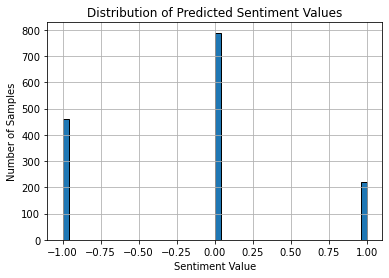

In [108]:
# Plotting the histogram for predicted values
plt.hist(fn_senti_ChatGPT['Dominant_prediction'], bins=50, edgecolor='black')
plt.title('Distribution of Predicted Sentiment Values')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

In [109]:
#save the results in pickle 
import pickle

with open ("fn_senti_ChatGPT.pkl", "wb") as file:
    pickle.dump(fn_senti_ChatGPT, file)